In [1]:
# Based on https://www.kaggle.com/general/74235
from google.colab import files
files.upload() # upload kaggle.json file to colab environment
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# download the dataset
!kaggle datasets download -d gpiosenka/100-bird-species
!unzip -q 100-bird-species.zip -d dataset
!rm 100-bird-species.zip

Saving kaggle.json to kaggle.json
 99% 1.48G/1.49G [00:19<00:00, 79.6MB/s]
100% 1.49G/1.49G [00:20<00:00, 79.6MB/s]


In [2]:
!pip install -q --upgrade fastai

     |████████████████████████████████| 189 kB 7.2 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 


In [41]:
from fastai.vision.all import *
from fastai.vision.widgets import *
import torchvision
path = Path('dataset/')

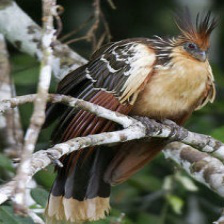

In [4]:
img = (path/'train'/'HOATZIN').ls()[0]
PILImage.create(img)

In [5]:
path.ls()

(#9) [Path('dataset/my_csv-2-17-2022-1-17-48.csv'),Path('dataset/birds.csv'),Path('dataset/test'),Path('dataset/valid'),Path('dataset/train'),Path('dataset/birds latin names.csv'),Path('dataset/class_dict.csv'),Path('dataset/images to test'),Path('dataset/EfficientNetB4-BIRDS-0.99.h5')]

In [6]:
birds = DataBlock(blocks=(ImageBlock,CategoryBlock),
                  get_items = partial(get_image_files,folders=['train','valid']),
                  splitter = RandomSplitter(seed=42),
                  get_y = parent_label,
                  item_tfms = Resize(150),
                  batch_tfms = aug_transforms(min_scale=0.75))

In [7]:
dls = birds.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [8]:
# test_dl = dls.test_dl(get_image_files(path/'test'),with_labels=True)

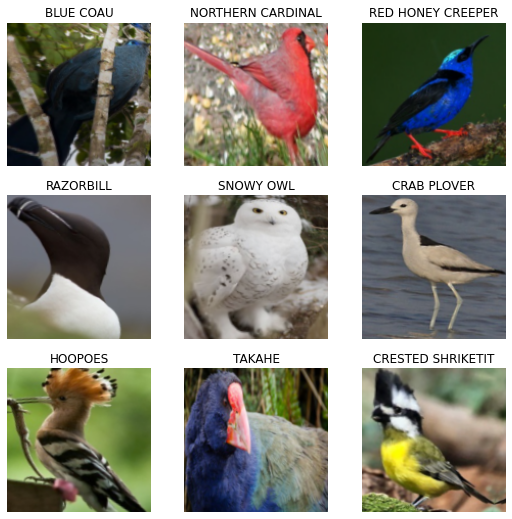

In [9]:
dls.show_batch()

In [10]:
!pip install timm

     |████████████████████████████████| 431 kB 8.1 MB/s 


In [11]:
from timm import create_model,list_models
from fastai.vision.learner import _update_first_layer

In [12]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [13]:
body = create_timm_body('efficientnetv2_rw_t', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnetv2_t_agc-3620981a.pth" to /root/.cache/torch/hub/checkpoints/efficientnetv2_t_agc-3620981a.pth


In [14]:
len(body)

7

In [15]:
nf = num_features_model(body); nf

1024

In [16]:
head = create_head(nf, dls.c,concat_pool=True)

In [17]:
net = nn.Sequential(body,head)

In [18]:
len(net)

2

In [19]:
learn = Learner(dls, net,splitter=default_split,metrics=accuracy)

In [20]:
learn.fine_tune(30,freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,3.183203,2.615767,0.486793,03:14
1,1.726036,1.219513,0.681543,03:07
2,1.380508,0.879054,0.761696,03:07


epoch,train_loss,valid_loss,accuracy,time
0,0.914117,0.639876,0.830587,04:10
1,0.789043,0.551536,0.853440,04:06
2,0.704867,0.485472,0.870415,04:05
3,0.604103,0.435841,0.883498,04:05
4,0.565316,0.410788,0.890287,04:05
5,0.506219,0.369007,0.903784,04:06
6,0.479113,0.350540,0.906020,04:06
7,0.491108,0.318900,0.917281,04:05
8,0.405983,0.305974,0.920179,04:06
9,0.372424,0.285006,0.927383,04:04


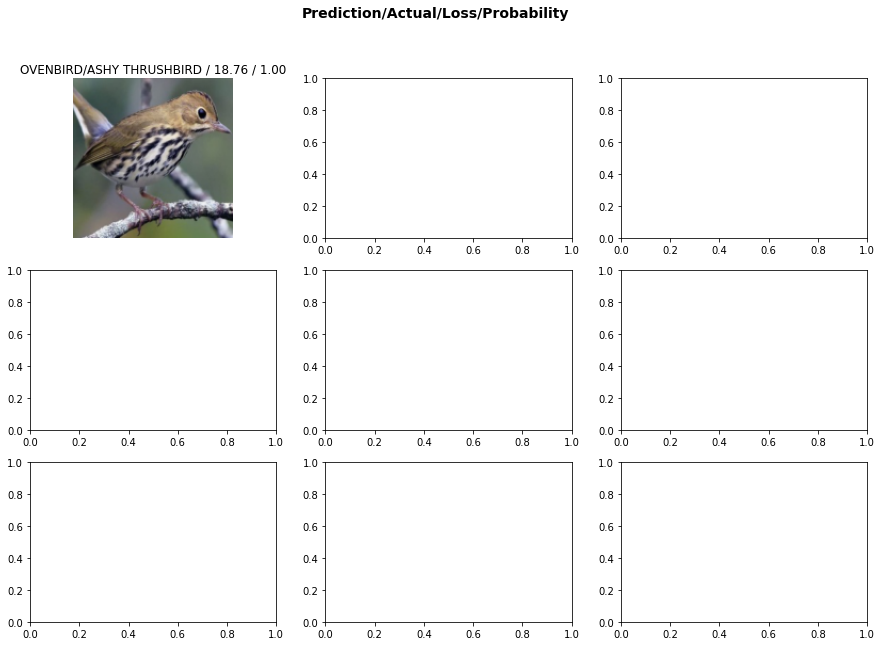

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

In [49]:
losses, idx = interp.top_losses()

In [23]:
interp.most_confused(min_val=3)

[('AVADAVAT', 'STRAWBERRY FINCH', 10),
 ('CROWNED PIGEON', 'VICTORIA CROWNED PIGEON', 7),
 ('BLUE COAU', 'CRESTED COUA', 6),
 ('STRAWBERRY FINCH', 'AVADAVAT', 6),
 ('AZURE JAY', 'CHARA DE COLLAR', 5),
 ('LESSER ADJUTANT', 'MARABOU STORK', 5),
 ('PINK ROBIN', 'ROBIN', 5),
 ('PURPLE FINCH', 'HOUSE FINCH', 5),
 ('EASTERN GOLDEN WEAVER', 'CANARY', 4),
 ('GUINEA TURACO', 'WHITE CHEEKED TURACO', 4),
 ('JAPANESE ROBIN', 'ROBIN', 4),
 ('WHITE CHEEKED TURACO', 'GUINEA TURACO', 4),
 ('ANDEAN LAPWING', 'MASKED LAPWING', 3),
 ('APOSTLEBIRD', 'GROVED BILLED ANI', 3),
 ('GILDED FLICKER', 'NORTHERN FLICKER', 3),
 ('LILAC ROLLER', 'INDIAN ROLLER', 3),
 ('RED FACED CORMORANT', 'BRANDT CORMARANT', 3),
 ('RED TAILED HAWK', 'GOLDEN EAGLE', 3),
 ('ROBIN', 'PINK ROBIN', 3),
 ('TREE SWALLOW', 'SAND MARTIN', 3),
 ('VULTURINE GUINEAFOWL', 'GUINEAFOWL', 3)]